<a href="https://colab.research.google.com/github/AbdElRahmanFarhan/box_semantic_segmentation/blob/main/evaluate_maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install pycocotools
!pip install coco-eval

## Mount Drive

In [24]:
import os
import wandb
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip Data

In [25]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')

## Load Validation Dataset

In [27]:
import torch
from torchvision.datasets import CocoDetection
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2


class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file, transforms=None)
        self._transforms = transforms

    def __len__(self) -> int:
       return super().__len__()

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        if anns:
          labels = []
          areas = []
          iscrowd = []
          masks = []
          boxes = []
          ids = []
          for ann in anns:
              x, y, w, h = list(map(int, ann['bbox']))
              boxes.append([x, y, x + w, y + h])
              labels.append(ann['category_id'])
              areas.append(ann['area'])
              iscrowd.append(ann['iscrowd'])
              mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
              masks.append(mask)
              ids.append(ann['id'])

          labels = torch.tensor(labels, dtype=torch.int64)
          areas = torch.tensor(areas, dtype=torch.float16)
          iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)
          boxes = torch.tensor(boxes, dtype=torch.int64)
          boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
          masks = torch.stack(masks, dim=0)
          ids = torch.tensor(ids, dtype=torch.int64)
          img_id = torch.tensor(ann['image_id'], dtype=torch.int64)

          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": img_id,
              "ids": ids,
              "area": areas,
              "iscrowd": iscrowd,
              "masks": Mask(masks),
          }
          img = tv_tensors.Image(img)
          if self._transforms is not None:
            img, target = self._transforms(img, target)
          return img, target

        else:

          target = {}
          img = tv_tensors.Image(img)
          img = v2.ToDtype(torch.float, scale=True)(img)
          return img, target


    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.bool)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [29]:
from torchvision.transforms import v2

def collate_fn(batch):
    images, targets = [], []
    for (image, target) in batch:
      if not target:
        pass
      else:
        images.append(image)
        targets.append(target)
    return images, targets

def get_transforms():
  transforms = []
  transforms.append(v2.ToDtype(torch.float32, scale=True))
  transforms.append(v2.ToPureTensor())
  return v2.Compose(transforms)

val_dataset = OSCDDataset(val_folder, val_annotation, transforms=get_transforms())
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


## Load The Model

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import RegionProposalNetwork
from torchvision.models.detection.rpn import AnchorGenerator


def create_model(num_classes=2,
                 rpn_fg_iou_thresh=0.7,
                 rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256,
                 rpn_positive_fraction=0.5,
                 rpn_nms_thresh=0.7,
                 rpn_pre_nms_top_n_train=2000,
                 rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000,
                 rpn_post_nms_top_n_test=1000,
                 rpn_score_thresh=0
                 ):

  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
  old_rpn = model.rpn

  post_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
  pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}

  # anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
  # aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
  # anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
  anchor_generator = old_rpn.anchor_generator
  new_rpn = RegionProposalNetwork(
          anchor_generator=anchor_generator,
          head=old_rpn.head,
          fg_iou_thresh=rpn_fg_iou_thresh,
          bg_iou_thresh=rpn_bg_iou_thresh,
          batch_size_per_image=rpn_batch_size_per_image,
          positive_fraction=rpn_positive_fraction,
          nms_thresh=rpn_nms_thresh,
          post_nms_top_n=post_nms_top_n,
          pre_nms_top_n=pre_nms_top_n,
          score_thresh=rpn_score_thresh
          )
  model.rpn = new_rpn
  return model

In [31]:
model_file = 'model_summer-sweep-1_wjpy11ya_10.pth'
model_path = os.path.join(dataset_folder, 'model', model_file)

model = create_model()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.to(device)
model.eval()
print("Model loader")

Model loader


## Predict for a Sample

In [32]:
indices = (5, 6, 9)
images = []
targets = []
for idx in indices:
  images.append(val_dataset[idx][0])
  targets.append(val_dataset[idx][1])
images = [image.to(device) for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
preds = model(images)

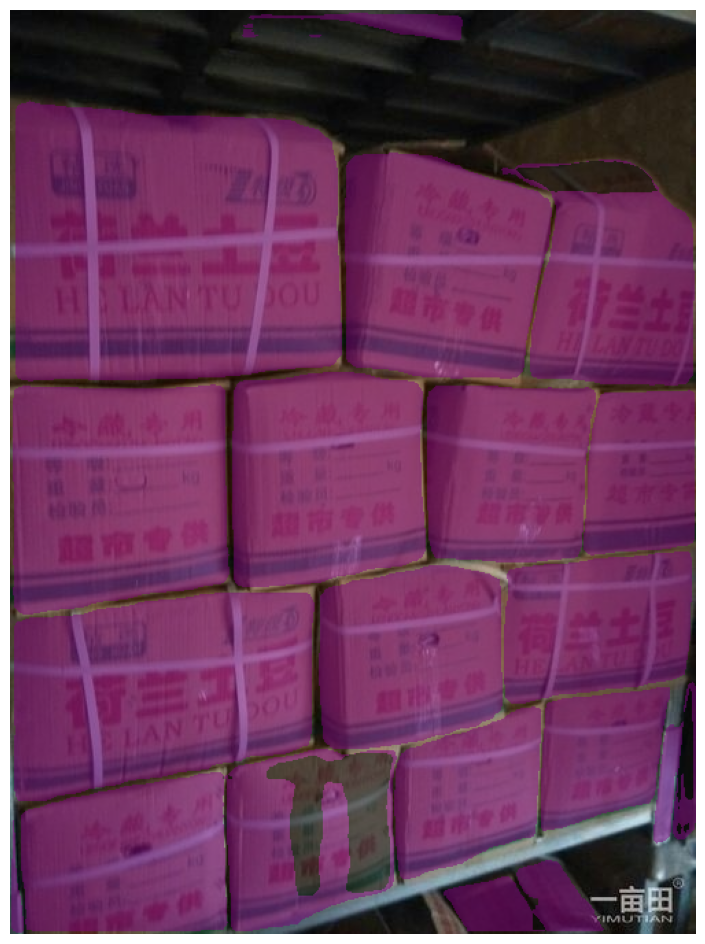

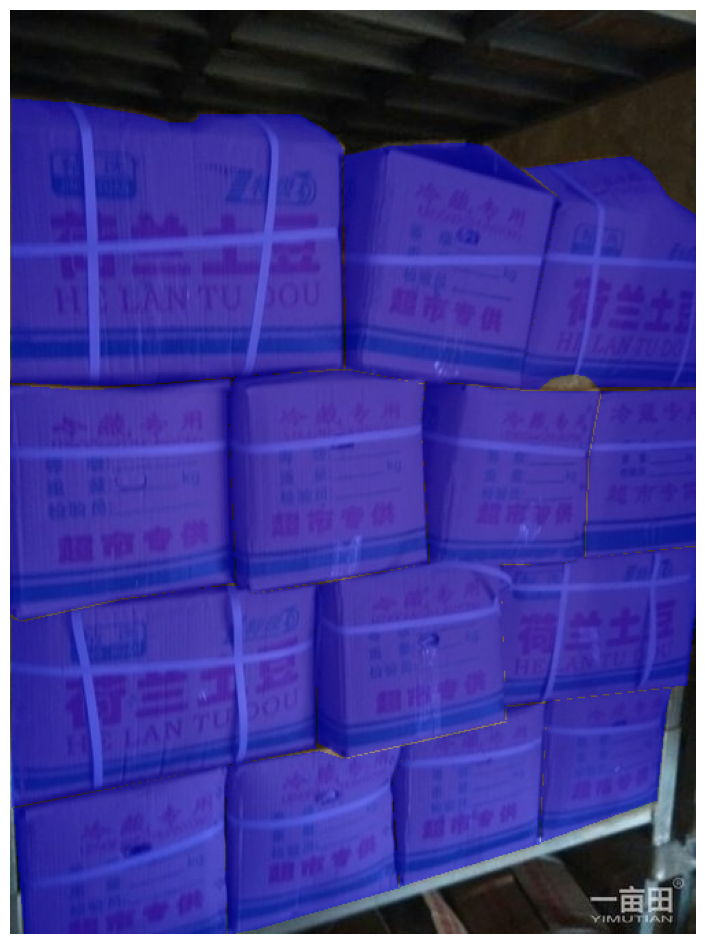

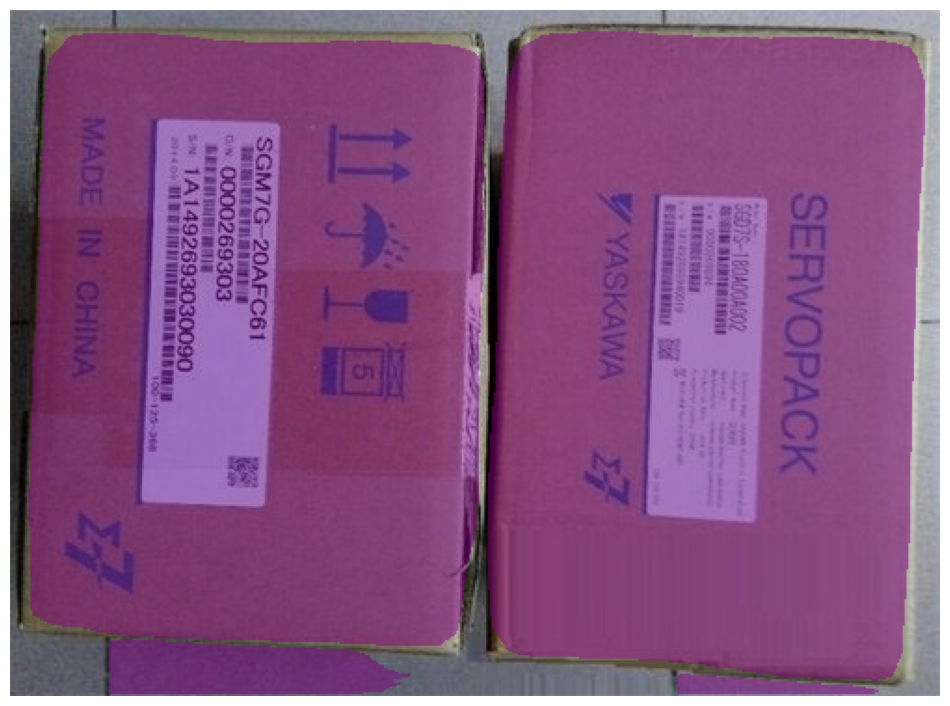

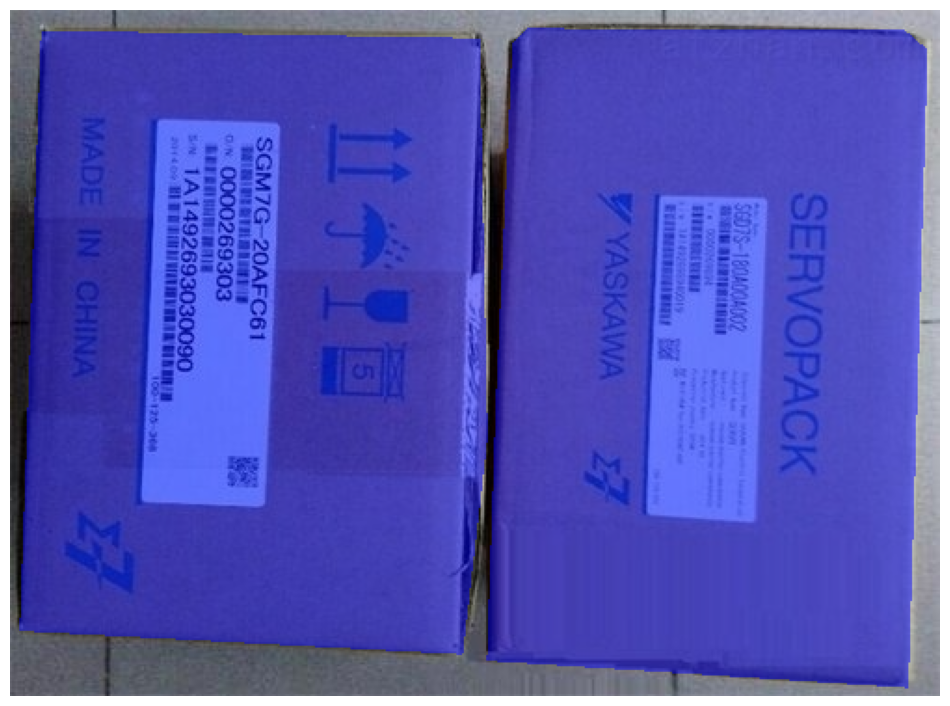

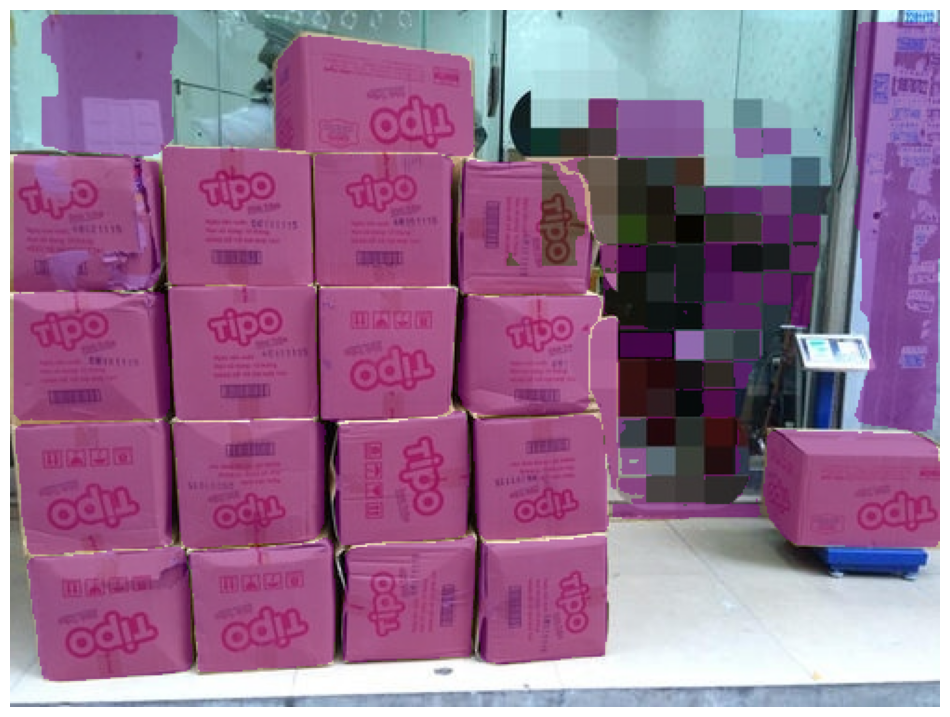

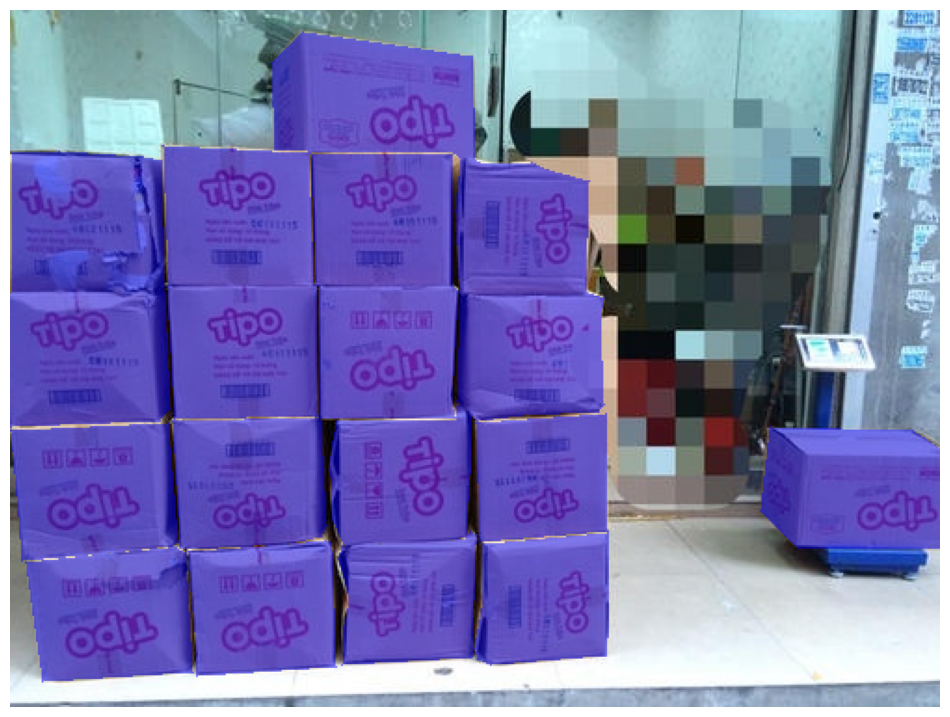

In [33]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import numpy as np

for i in range(len(images)):
  img = images[i]
  pred = preds[i]
  target = targets[i]
  pred_boxes = pred["boxes"]
  pred_labels = pred["labels"]


  # plt_img = draw_bounding_boxes(img, pred_boxes, colors="red")
  pred_masks = (pred["masks"] > 0.7).squeeze(1)
  pred_colors = np.linspace((0, 0, 255), (0, 255, 255), num=len(pred_masks), dtype=int).tolist()
  plt_img = draw_segmentation_masks(img, pred_masks, alpha=0.5, colors="purple")
  plt.figure(figsize=(12, 12))
  plt.imshow(plt_img.cpu().permute(1, 2, 0))
  plt.axis('off')

  target_boxes = target["boxes"]
  target_labels = target["labels"]
  # plt_img = draw_bounding_boxes(img, target_boxes, colors="red")
  target_masks = (target["masks"] > 0.7).squeeze(1)
  target_colors = np.linspace((255, 0, 255), (0, 255, 255), num=len(pred_masks), dtype=int).tolist()
  plt_img = draw_segmentation_masks(img, target_masks, alpha=0.5, colors="blue")
  plt.figure(figsize=(12, 12))
  plt.imshow(plt_img.cpu().permute(1, 2, 0))
  plt.axis('off')
plt.show()

## Evaluation

In [34]:
from coco_eval import CocoEvaluator
import numpy as np
import pycocotools.mask as mask_util

def prepare_for_coco_segmentation(predictions, targets):
    coco_results = []
    for prediction, target in zip(predictions, targets):
        masks = prediction["masks"]
        masks = masks > 0.5
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()
        rles = [
            mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
        ]
        for rle in rles:
            rle["counts"] = rle["counts"].decode("utf-8")
        coco_results.extend(
            [
                {
                    "image_id": target["image_id"].item(),
                    "category_id": labels[k],
                    "segmentation": rle,
                    "score": scores[k],
                }
                for k, rle in enumerate(rles)
            ]
        )
    return coco_results

def evaluate(model, data_loader, device):
    model.eval()
    coco_eval = CocoEvaluator(data_loader.dataset.coco, ['segm'])
    for i, (images, targets) in enumerate(data_loader):
      if not targets:
        continue
      images = [image.to(device) for image in images]
      with torch.no_grad():
        predictions = model(images)
        predictions = [{k: v.to('cpu') for k, v in o.items()} for o in predictions]
        coco_results = prepare_for_coco_segmentation(predictions, targets)
        coco_eval.update(coco_results)
    coco_eval.synchronize_between_processes()
    coco_eval.accumulate()
    return coco_eval

In [35]:
eval = evaluate(model, val_loader, device)
eval.summarize()

Accumulating evaluation results...
DONE (t=0.36s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.782
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.895
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.827
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.825
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la